# Machine Learning with PyTorch and Scikit-Learn

In [294]:
from IPython.display import Image
%matplotlib inline

In [295]:
import keras
import numpy as np
import pandas as pd
import sklearn

In [296]:
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()

In [297]:
# Combine train and test to match OpenML's full dataset size
X = np.vstack([x_train, x_test])  # Combine training and test images
y = np.hstack([y_train, y_test])  # Combine training and test labels

In [298]:
# Reshape to match OpenML's format (70000, 784)
X = X.reshape(70000, 784)

In [299]:
# Convert to same data types as OpenML
X = X.astype('float64')  # OpenML returns float64
y = y.astype(int)

In [300]:
print(X.shape)
print(y.shape)

(70000, 784)
(70000,)


In [301]:
# from sklearn.datasets import fetch_openml


# X, y = fetch_openml('mnist_784', version=1, return_X_y=True)
# X = X.values
# y = y.astype(int).values

# print(X.shape)
# print(y.shape)

Normalize to [-1, 1] range:

In [302]:
X = ((X / 255.) - .5) * 2

Visualize the first digit of each class:

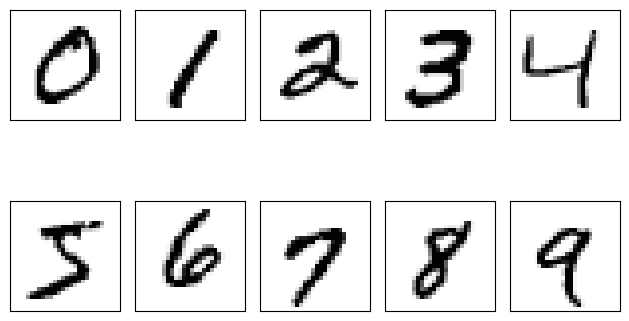

In [303]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(nrows=2, ncols=5, sharex=True, sharey=True)
ax = ax.flatten()
for i in range(10):
    img = X[y == i][0].reshape(28, 28)
    ax[i].imshow(img, cmap='Greys')

ax[0].set_xticks([])
ax[0].set_yticks([])
plt.tight_layout()
plt.show()

Visualize 25 different versions of "7":

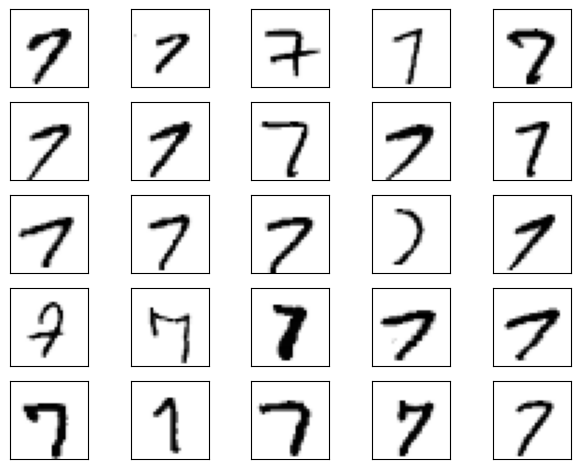

In [304]:
fig, ax = plt.subplots(nrows=5, ncols=5, sharex=True, sharey=True)
ax = ax.flatten()
for i in range(25):
    img = X[y == 7][i].reshape(28, 28)
    ax[i].imshow(img, cmap='Greys')

ax[0].set_xticks([])
ax[0].set_yticks([])
plt.tight_layout()
plt.show()

Split into training, validation, and test set:

According to the assignment: train 70% test 30%

In [305]:
from sklearn.model_selection import train_test_split


X_temp, X_test, y_temp, y_test = train_test_split(
    X, y, test_size=0.7, random_state=123, stratify=y)

X_train, X_valid, y_train, y_valid = train_test_split(
    X_temp, y_temp, test_size=0.3, random_state=123, stratify=y_temp)


# optional to free up some memory by deleting non-used arrays:
del X_temp, y_temp, X, y

## Implementing a multi-layer perceptron

In [306]:
import numpy as np

In [307]:
##########################
### MODEL
##########################

def sigmoid(z):
    return 1. / (1. + np.exp(-z))

def int_to_onehot(y, num_labels):
    ary = np.zeros((y.shape[0], num_labels))
    for i, val in enumerate(y):
        ary[i, val] = 1
    return ary

class NeuralNetMLP:
    def __init__(self, num_features, num_hidden1, num_hidden2=None, num_classes=10, random_seed=123):
        super().__init__()

        self.num_classes = num_classes

        self.num_hidden2 = num_hidden2

        rng = np.random.RandomState(random_seed)

        # First hidden layer
        self.weight_h1 = rng.normal(
            loc=0.0, scale=0.1, size=(num_hidden1, num_features))
        self.bias_h1 = np.zeros(num_hidden1)

        if num_hidden2:
            # Second hidden layer
            self.weight_h2 = rng.normal(
                loc=0.0, scale=0.1, size=(num_hidden2, num_hidden1))
            self.bias_h2 = np.zeros(num_hidden2)

        # Output layer
        self.weight_out = rng.normal(
            loc=0.0, scale=0.1, size=(num_classes, num_hidden2 if num_hidden2 else num_hidden1))
        self.bias_out = np.zeros(num_classes)

    def forward(self, x):
        # First hidden layer
        z_h1 = np.dot(x, self.weight_h1.T) + self.bias_h1
        a_h1 = sigmoid(z_h1)

        if self.num_hidden2:
            # Second hidden layer
            z_h2 = np.dot(a_h1, self.weight_h2.T) + self.bias_h2
            a_h2 = sigmoid(z_h2)

            # Output layer
            z_out = np.dot(a_h2, self.weight_out.T) + self.bias_out
            a_out = sigmoid(z_out)
            return a_h1, a_h2, a_out
        else:
            # Output layer
            z_out = np.dot(a_h1, self.weight_out.T) + self.bias_out
            a_out = sigmoid(z_out)
            return a_h1, a_out

    def backward(self, x, a_h1, a_h2, a_out, y):
        y_onehot = int_to_onehot(y, self.num_classes)

        # Gradients for the output layer
        d_loss__d_a_out = 2.*(a_out - y_onehot) / y.shape[0]
        d_a_out__d_z_out = a_out * (1. - a_out)
        delta_out = d_loss__d_a_out * d_a_out__d_z_out

        d_z_out__d_w_out = a_h2 if self.num_hidden2 else a_h1
        d_loss__dw_out = np.dot(delta_out.T, d_z_out__d_w_out)
        d_loss__db_out = np.sum(delta_out, axis=0)

        if self.num_hidden2:
            # Gradients for the second hidden layer
            d_z_out__a_h2 = self.weight_out
            d_loss__a_h2 = np.dot(delta_out, d_z_out__a_h2)
            d_a_h2__d_z_h2 = a_h2 * (1. - a_h2)
            delta_h2 = d_loss__a_h2 * d_a_h2__d_z_h2

            d_z_h2__d_w_h2 = a_h1
            d_loss__d_w_h2 = np.dot(delta_h2.T, d_z_h2__d_w_h2)
            d_loss__d_b_h2 = np.sum(delta_h2, axis=0)

            # Gradients for the first hidden layer
            d_z_h2__a_h1 = self.weight_h2
            d_loss__a_h1 = np.dot(delta_h2, d_z_h2__a_h1)
            d_a_h1__d_z_h1 = a_h1 * (1. - a_h1)
            delta_h1 = d_loss__a_h1 * d_a_h1__d_z_h1

            d_z_h1__d_w_h1 = x
            d_loss__d_w_h1 = np.dot(delta_h1.T, d_z_h1__d_w_h1)
            d_loss__d_b_h1 = np.sum(delta_h1, axis=0)

            return (d_loss__dw_out, d_loss__db_out,
                    d_loss__d_w_h2, d_loss__d_b_h2,
                    d_loss__d_w_h1, d_loss__d_b_h1)
        else:
            # Gradients for the first hidden layer (single hidden layer case)
            d_z_out__a_h1 = self.weight_out
            d_loss__a_h1 = np.dot(delta_out, d_z_out__a_h1)
            d_a_h1__d_z_h1 = a_h1 * (1. - a_h1)
            delta_h1 = d_loss__a_h1 * d_a_h1__d_z_h1

            d_z_h1__d_w_h1 = x
            d_loss__d_w_h1 = np.dot(delta_h1.T, d_z_h1__d_w_h1)
            d_loss__d_b_h1 = np.sum(delta_h1, axis=0)

            return (d_loss__dw_out, d_loss__db_out,
                    d_loss__d_w_h1, d_loss__d_b_h1)


In [308]:
model1 = NeuralNetMLP(num_features=28*28,
                     num_hidden1=50,
                     num_classes=10)
model2 = NeuralNetMLP(num_features=28*28,
                     num_hidden1=50,
                     num_hidden2=30,
                     num_classes=10)

## Coding the neural network training loop

Defining data loaders:

In [309]:
import numpy as np

num_epochs = 50
minibatch_size = 100


def minibatch_generator(X, y, minibatch_size):
    indices = np.arange(X.shape[0])
    np.random.shuffle(indices)

    for start_idx in range(0, indices.shape[0] - minibatch_size
                           + 1, minibatch_size):
        batch_idx = indices[start_idx:start_idx + minibatch_size]

        yield X[batch_idx], y[batch_idx]


# iterate over training epochs
for i in range(num_epochs):

    # iterate over minibatches
    minibatch_gen = minibatch_generator(
        X_train, y_train, minibatch_size)

    for X_train_mini, y_train_mini in minibatch_gen:

        break

    break

print(X_train_mini.shape)
print(y_train_mini.shape)

(100, 784)
(100,)


Defining a function to compute the loss and accuracy

In [310]:
def mse_loss(targets, probas, num_labels=10):
    onehot_targets = int_to_onehot(targets, num_labels=num_labels)
    return np.mean((onehot_targets - probas)**2)


def accuracy(targets, predicted_labels):
    return np.mean(predicted_labels == targets)


_, probas1 = model1.forward(X_valid)
mse1 = mse_loss(y_valid, probas1)
___, __, probas2 = model2.forward(X_valid)
mse2 = mse_loss(y_valid, probas2)

predicted_labels1 = np.argmax(probas1, axis=1)
acc1 = accuracy(y_valid, predicted_labels1)
predicted_labels2 = np.argmax(probas2, axis=1)
acc2 = accuracy(y_valid, predicted_labels2)

print(f'Initial validation MSE: {mse1:.1f}')
print(f'Initial validation accuracy: {acc1*100:.1f}%')
print(f'Initial validation MSE: {mse2:.1f}')
print(f'Initial validation accuracy: {acc2*100:.1f}%')

Initial validation MSE: 0.3
Initial validation accuracy: 9.0%
Initial validation MSE: 0.2
Initial validation accuracy: 9.6%


In [311]:
def compute_mse_and_acc(nnet, X, y, num_labels=10, minibatch_size=100):
    mse, correct_pred, num_examples = 0., 0, 0
    minibatch_gen = minibatch_generator(X, y, minibatch_size)

    for i, (features, targets) in enumerate(minibatch_gen):

        if nnet.num_hidden2:
            _, _, probas = nnet.forward(features)
        else:
          _, probas = nnet.forward(features)
        predicted_labels = np.argmax(probas, axis=1)

        onehot_targets = int_to_onehot(targets, num_labels=num_labels)
        loss = np.mean((onehot_targets - probas)**2)
        correct_pred += (predicted_labels == targets).sum()

        num_examples += targets.shape[0]
        mse += loss

    mse = mse/(i+1)
    acc = correct_pred/num_examples
    return mse, acc

In [312]:
mse1, acc1 = compute_mse_and_acc(model1, X_valid, y_valid)
mse2, acc2 = compute_mse_and_acc(model2, X_valid, y_valid)
print(f'Initial valid MSE1: {mse1:.1f}')
print(f'Initial valid accuracy1: {acc1*100:.1f}%')
print(f'Initial valid MSE2: {mse2:.1f}')
print(f'Initial valid accuracy2: {acc2*100:.1f}%')

Initial valid MSE1: 0.3
Initial valid accuracy1: 9.0%
Initial valid MSE2: 0.2
Initial valid accuracy2: 9.6%


In [313]:
from sklearn.metrics import roc_auc_score

In [314]:
def compute_macro_auc(model, X, y):
    if model.num_hidden2:
        _, _, probas = model.forward(X)
    else:
        _, probas = model.forward(X)
    y_onehot = int_to_onehot(y, num_labels=model.num_classes)
    macro_auc = roc_auc_score(y_onehot, probas, multi_class="ovr", average="macro")
    return macro_auc

In [315]:
auc1 = compute_macro_auc(model1, X_valid, y_valid)
auc2 = compute_macro_auc(model2, X_valid, y_valid)
print(f'Initial valid AUC1: {auc1:.1f}')
print(f'Initial valid AUC2: {auc2:.1f}')

Initial valid AUC1: 0.5
Initial valid AUC2: 0.5


In [316]:
def train(model, X_train, y_train, X_valid, y_valid, num_epochs, learning_rate=0.1):
    epoch_loss = []
    epoch_train_acc = []
    epoch_valid_acc = []
    epoch_train_auc = []
    epoch_valid_auc = []

    for e in range(num_epochs):
        minibatch_gen = minibatch_generator(X_train, y_train, minibatch_size=100)

        for X_train_mini, y_train_mini in minibatch_gen:
            if model.num_hidden2:
                a_h1, a_h2, a_out = model.forward(X_train_mini)
                gradients = model.backward(X_train_mini, a_h1, a_h2, a_out, y_train_mini)
                d_loss__dw_out, d_loss__db_out, d_loss__d_w_h2, d_loss__d_b_h2, d_loss__d_w_h1, d_loss__d_b_h1 = gradients

                model.weight_h2 -= learning_rate * d_loss__d_w_h2
                model.bias_h2 -= learning_rate * d_loss__d_b_h2
            else:
                a_h1, a_out = model.forward(X_train_mini)
                gradients = model.backward(X_train_mini, a_h1, None, a_out, y_train_mini)
                d_loss__dw_out, d_loss__db_out, d_loss__d_w_h1, d_loss__d_b_h1 = gradients

            model.weight_h1 -= learning_rate * d_loss__d_w_h1
            model.bias_h1 -= learning_rate * d_loss__d_b_h1
            model.weight_out -= learning_rate * d_loss__dw_out
            model.bias_out -= learning_rate * d_loss__db_out

        train_mse, train_acc = compute_mse_and_acc(model, X_train, y_train)
        valid_mse, valid_acc = compute_mse_and_acc(model, X_valid, y_valid)
        train_auc = compute_macro_auc(model, X_train, y_train)
        valid_auc = compute_macro_auc(model, X_valid, y_valid)

        epoch_loss.append(train_mse)
        epoch_train_acc.append(train_acc * 100)
        epoch_valid_acc.append(valid_acc * 100)
        epoch_train_auc.append(train_auc)
        epoch_valid_auc.append(valid_auc)

        print(f"Epoch: {e+1:03d}/{num_epochs:03d} | Train MSE: {train_mse:.4f} | Train Acc: {train_acc * 100:.2f}% | Valid Acc: {valid_acc * 100:.2f}% | Train AUC: {train_auc:.4f} | Valid AUC: {valid_auc:.4f}")

    return epoch_loss, epoch_train_acc, epoch_valid_acc, epoch_train_auc, epoch_valid_auc


In [317]:
num_epochs = 20
np.random.seed(123) # for the training set shuffling

epoch_loss1, epoch_train_acc1, epoch_valid_acc1, epoch_train_auc1, epoch_valid_auc1 = train(
    model1, X_train, y_train, X_valid, y_valid,
    num_epochs=num_epochs, learning_rate=0.1)

Epoch: 001/020 | Train MSE: 0.0831 | Train Acc: 39.71% | Valid Acc: 39.68% | Train AUC: 0.8311 | Valid AUC: 0.8314
Epoch: 002/020 | Train MSE: 0.0706 | Train Acc: 63.20% | Valid Acc: 62.52% | Train AUC: 0.9161 | Valid AUC: 0.9172
Epoch: 003/020 | Train MSE: 0.0578 | Train Acc: 73.03% | Valid Acc: 73.33% | Train AUC: 0.9419 | Valid AUC: 0.9430
Epoch: 004/020 | Train MSE: 0.0477 | Train Acc: 78.59% | Valid Acc: 78.59% | Train AUC: 0.9523 | Valid AUC: 0.9531
Epoch: 005/020 | Train MSE: 0.0409 | Train Acc: 80.92% | Valid Acc: 80.98% | Train AUC: 0.9587 | Valid AUC: 0.9595
Epoch: 006/020 | Train MSE: 0.0361 | Train Acc: 83.31% | Valid Acc: 83.27% | Train AUC: 0.9644 | Valid AUC: 0.9651
Epoch: 007/020 | Train MSE: 0.0325 | Train Acc: 84.79% | Valid Acc: 84.67% | Train AUC: 0.9686 | Valid AUC: 0.9694
Epoch: 008/020 | Train MSE: 0.0297 | Train Acc: 85.80% | Valid Acc: 85.98% | Train AUC: 0.9719 | Valid AUC: 0.9727
Epoch: 009/020 | Train MSE: 0.0275 | Train Acc: 86.73% | Valid Acc: 86.92% | Tra

In [318]:
epoch_loss2, epoch_train_acc2, epoch_valid_acc2, epoch_train_auc2, epoch_valid_auc2 = train(
    model2, X_train, y_train, X_valid, y_valid,
    num_epochs=num_epochs, learning_rate=0.1)

Epoch: 001/020 | Train MSE: 0.0898 | Train Acc: 11.25% | Valid Acc: 11.25% | Train AUC: 0.6049 | Valid AUC: 0.6073
Epoch: 002/020 | Train MSE: 0.0897 | Train Acc: 11.31% | Valid Acc: 11.29% | Train AUC: 0.6574 | Valid AUC: 0.6597
Epoch: 003/020 | Train MSE: 0.0895 | Train Acc: 16.85% | Valid Acc: 16.70% | Train AUC: 0.7027 | Valid AUC: 0.7054
Epoch: 004/020 | Train MSE: 0.0893 | Train Acc: 18.78% | Valid Acc: 17.97% | Train AUC: 0.7418 | Valid AUC: 0.7441
Epoch: 005/020 | Train MSE: 0.0891 | Train Acc: 19.60% | Valid Acc: 19.10% | Train AUC: 0.7744 | Valid AUC: 0.7764
Epoch: 006/020 | Train MSE: 0.0888 | Train Acc: 23.49% | Valid Acc: 23.46% | Train AUC: 0.8016 | Valid AUC: 0.8033
Epoch: 007/020 | Train MSE: 0.0883 | Train Acc: 24.28% | Valid Acc: 24.29% | Train AUC: 0.8238 | Valid AUC: 0.8252
Epoch: 008/020 | Train MSE: 0.0875 | Train Acc: 26.53% | Valid Acc: 27.02% | Train AUC: 0.8400 | Valid AUC: 0.8414
Epoch: 009/020 | Train MSE: 0.0863 | Train Acc: 27.01% | Valid Acc: 27.19% | Tra

## Evaluating the neural network performance

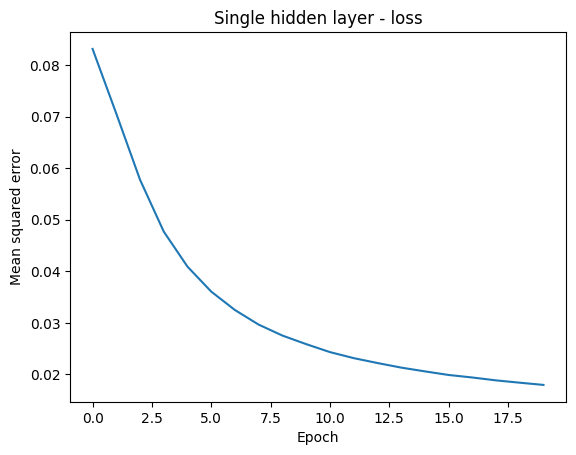

In [319]:
plt.plot(range(len(epoch_loss1)), epoch_loss1)
plt.title('Single hidden layer - loss')
plt.ylabel('Mean squared error')
plt.xlabel('Epoch')
#plt.savefig('figures/11_07.png', dpi=300)
plt.show()

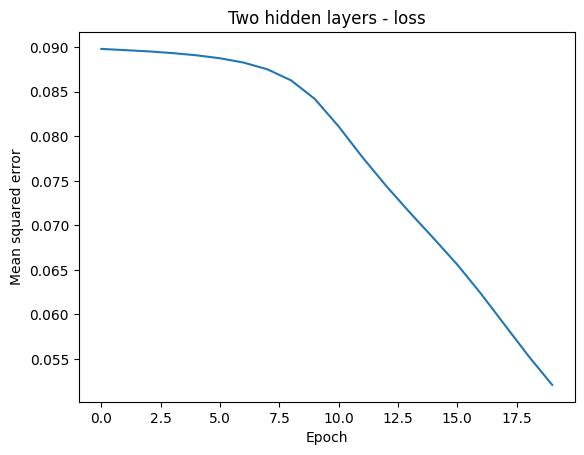

In [320]:
plt.plot(range(len(epoch_loss2)), epoch_loss2)
plt.title('Two hidden layers - loss')
plt.ylabel('Mean squared error')
plt.xlabel('Epoch')
#plt.savefig('figures/11_07.png', dpi=300)
plt.show()

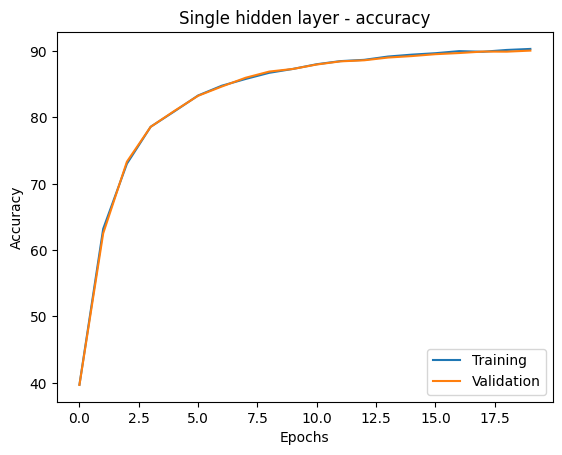

In [321]:
plt.plot(range(len(epoch_train_acc1)), epoch_train_acc1,
         label='Training')
plt.plot(range(len(epoch_valid_acc1)), epoch_valid_acc1,
         label='Validation')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(loc='lower right')
plt.title('Single hidden layer - accuracy')
#plt.savefig('figures/11_08.png', dpi=300)
plt.show()

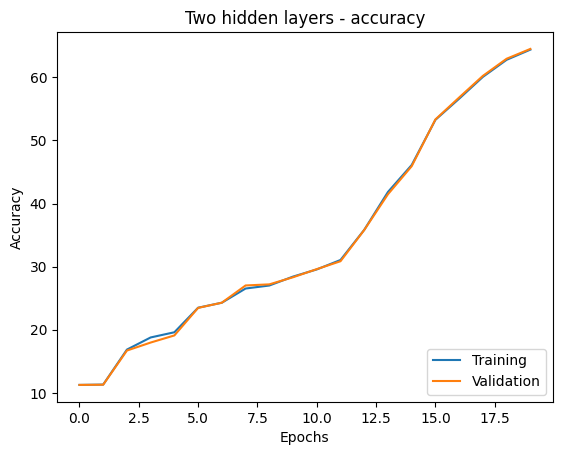

In [322]:
plt.plot(range(len(epoch_train_acc2)), epoch_train_acc2,
         label='Training')
plt.plot(range(len(epoch_valid_acc2)), epoch_valid_acc2,
         label='Validation')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(loc='lower right')
plt.title('Two hidden layers - accuracy')
#plt.savefig('figures/11_08.png', dpi=300)
plt.show()

In [323]:
test_mse1, test_acc1 = compute_mse_and_acc(model1, X_test, y_test)
print(f'Test accuracy for single hidden layer: {test_acc1*100:.2f}%')

Test accuracy for single hidden layer: 90.19%


In [324]:
test_mse2, test_acc2 = compute_mse_and_acc(model2, X_test, y_test)
print(f'Test accuracy for two hidden layers: {test_acc2*100:.2f}%')

Test accuracy for two hidden layers: 64.74%


Plot failure cases:

In [325]:
X_test_subset1 = X_test[:1000, :]
y_test_subset1 = y_test[:1000]

_, probas1 = model1.forward(X_test_subset1)
test_pred1 = np.argmax(probas1, axis=1)

misclassified_images1 = X_test_subset1[y_test_subset1 != test_pred1][:25]
misclassified_labels1 = test_pred1[y_test_subset1 != test_pred1][:25]
correct_labels1 = y_test_subset1[y_test_subset1 != test_pred1][:25]

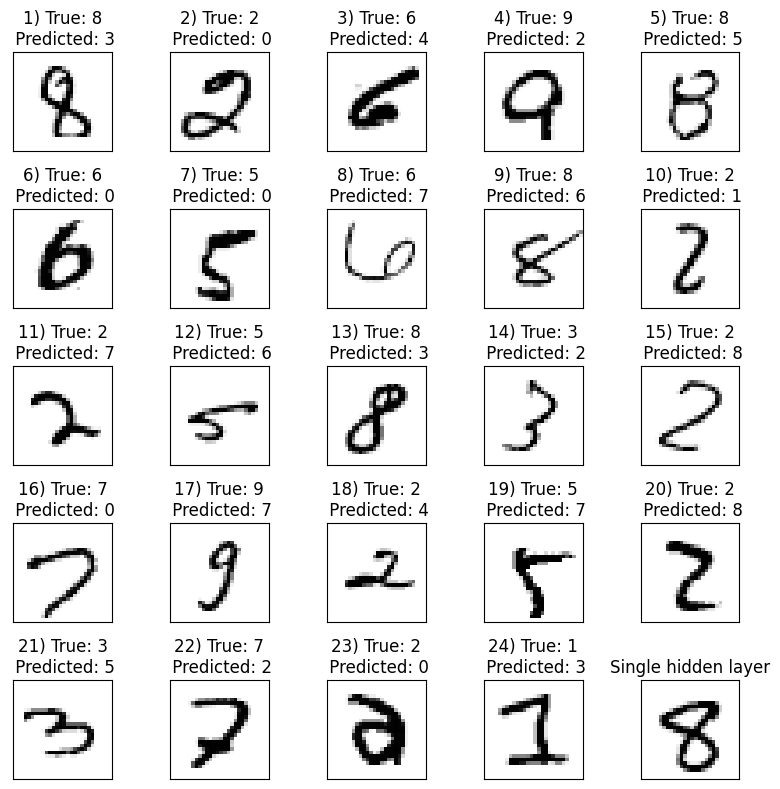

In [326]:
fig, ax = plt.subplots(nrows=5, ncols=5,
                       sharex=True, sharey=True, figsize=(8, 8))
ax = ax.flatten()
for i in range(25):
    img = misclassified_images1[i].reshape(28, 28)
    ax[i].imshow(img, cmap='Greys', interpolation='nearest')
    ax[i].set_title(f'{i+1}) '
                    f'True: {correct_labels1[i]}\n'
                    f' Predicted: {misclassified_labels1[i]}')

ax[0].set_xticks([])
ax[0].set_yticks([])
plt.tight_layout()
plt.title('Single hidden layer')
#plt.savefig('figures/11_09.png', dpi=300)
plt.show()

In [327]:
X_test_subset2 = X_test[:1000, :]
y_test_subset2 = y_test[:1000]

_, _, probas2 = model2.forward(X_test_subset2)
test_pred2 = np.argmax(probas2, axis=1)

misclassified_images2 = X_test_subset2[y_test_subset2 != test_pred2][:25]
misclassified_labels2 = test_pred2[y_test_subset2 != test_pred2][:25]
correct_labels2 = y_test_subset2[y_test_subset2 != test_pred2][:25]

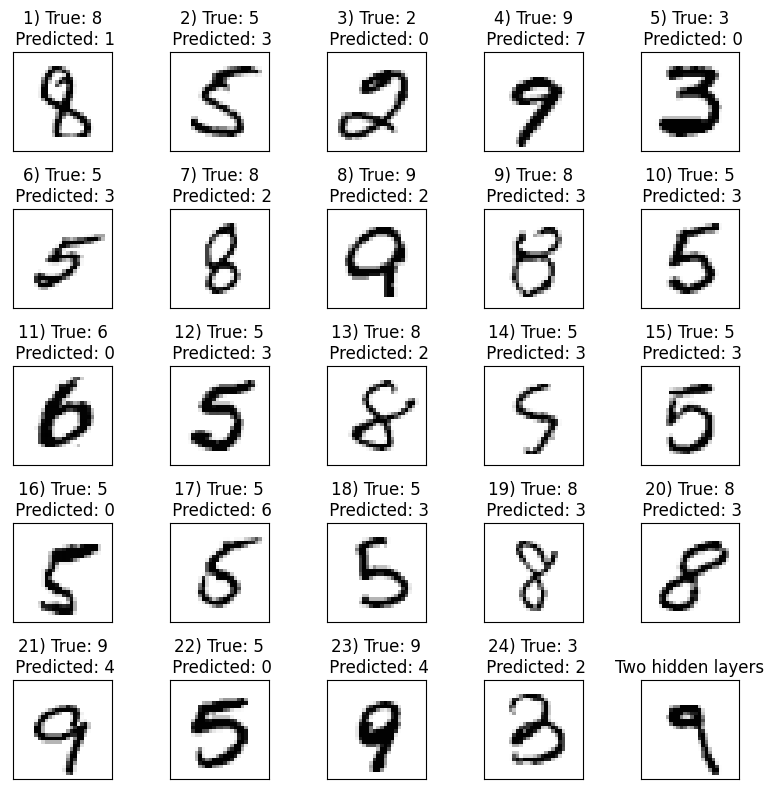

In [328]:
fig, ax = plt.subplots(nrows=5, ncols=5,
                       sharex=True, sharey=True, figsize=(8, 8))
ax = ax.flatten()
for i in range(25):
    img = misclassified_images2[i].reshape(28, 28)
    ax[i].imshow(img, cmap='Greys', interpolation='nearest')
    ax[i].set_title(f'{i+1}) '
                    f'True: {correct_labels2[i]}\n'
                    f' Predicted: {misclassified_labels2[i]}')

ax[0].set_xticks([])
ax[0].set_yticks([])
plt.tight_layout()
plt.title('Two hidden layers')
#plt.savefig('figures/11_09.png', dpi=300)
plt.show()

<br>
<br>

# Training an artificial neural network

In [357]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from torch.autograd import Variable
from sklearn.metrics import roc_auc_score
from tqdm import tqdm
from sklearn.metrics import *
from matplotlib import pyplot as plt
%matplotlib inline

# Check Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


batch_size_train = 64
batch_size_test = 1000
learning_rate = 0.01
input_size = 784
num_classes = 10
num_epochs = 20
hidden1_size = 128
hidden2_size = 64

In [344]:
# Load and preprocess the MNIST dataset
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))])
train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

In [345]:
# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=batch_size_train, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size_test, shuffle=True)

In [346]:
# Define the PyTorch model
class PyTorchMLP(nn.Module):
    def __init__(self, input_size, hidden1_size, hidden2_size, num_classes):
      super(PyTorchMLP, self).__init__()
      # nn.Flatten()
      self.fc1 = nn.Linear(input_size, hidden1_size)
      self.fc2 = nn.Linear(hidden1_size, hidden2_size)
      self.fc3 = nn.Linear(hidden2_size, num_classes)

    def forward(self, x):
      out = F.relu(self.fc1(x))
      out = F.relu(self.fc2(out))
      out = self.fc3(out)
      return out

In [347]:
# Initialize the model, loss function and optimizer
model = PyTorchMLP(input_size, hidden1_size, hidden2_size,num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=learning_rate)

In [348]:
def train(model, train_loader, epoch):
  losses = []
  model.train()
  for batch_idx, (data, target) in enumerate(train_loader):
    data = data.reshape(-1, 28*28).to(device)
    target = target.to(device)
    optimizer.zero_grad()
    output = model(data)
    loss = criterion(output, target)
    loss.backward()
    optimizer.step()
    losses.append(loss.item())
    if batch_idx > 0 and batch_idx % 100 == 0:
          print('Train Epoch: {} [{}/{}\t({:.0f}%)]\tLoss: {:.6f}'.format(
              epoch, batch_idx * len(data), len(train_loader.dataset),
              100. * batch_idx / len(train_loader), loss.item()))
  return losses

In [349]:
# validation
def test_accuracy(model, test_loader):
  model.eval()
  test_loss = 0
  correct = 0
  with torch.no_grad():
    for data, target in test_loader:
      data = data.reshape(-1, 28*28).to(device)
      target = target.to(device)
      output = model(data)
      test_loss += F.cross_entropy(output, target, reduction='sum').item() # sum up batch loss
      pred = output.argmax(dim=1, keepdim=True) # get the index of the max log-probability
      correct += pred.eq(target.view_as(pred)).sum().item()
  test_loss /= len(test_loader.dataset)
  print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
      test_loss, correct, len(test_loader.dataset),
      100. * correct / len(test_loader.dataset)))
  return (float(correct) / len(test_loader.dataset))

In [350]:
losses = []
accuracies = []
for epoch in range(num_epochs):
    losses.extend(train(model, train_loader, epoch))
    accuracies.append(test_accuracy(model, train_loader))

Train Epoch: 0 [6400/60000	(11%)]	Loss: 1.994813
Train Epoch: 0 [12800/60000	(21%)]	Loss: 1.416150
Train Epoch: 0 [19200/60000	(32%)]	Loss: 0.804940
Train Epoch: 0 [25600/60000	(43%)]	Loss: 0.602295
Train Epoch: 0 [32000/60000	(53%)]	Loss: 0.494042
Train Epoch: 0 [38400/60000	(64%)]	Loss: 0.394693
Train Epoch: 0 [44800/60000	(75%)]	Loss: 0.409190
Train Epoch: 0 [51200/60000	(85%)]	Loss: 0.354417
Train Epoch: 0 [57600/60000	(96%)]	Loss: 0.257929

Test set: Average loss: 0.3590, Accuracy: 53999/60000 (90%)

Train Epoch: 1 [6400/60000	(11%)]	Loss: 0.257302
Train Epoch: 1 [12800/60000	(21%)]	Loss: 0.278859
Train Epoch: 1 [19200/60000	(32%)]	Loss: 0.360212
Train Epoch: 1 [25600/60000	(43%)]	Loss: 0.378190
Train Epoch: 1 [32000/60000	(53%)]	Loss: 0.169802
Train Epoch: 1 [38400/60000	(64%)]	Loss: 0.319061
Train Epoch: 1 [44800/60000	(75%)]	Loss: 0.281738
Train Epoch: 1 [51200/60000	(85%)]	Loss: 0.635887
Train Epoch: 1 [57600/60000	(96%)]	Loss: 0.243078

Test set: Average loss: 0.2737, Accurac

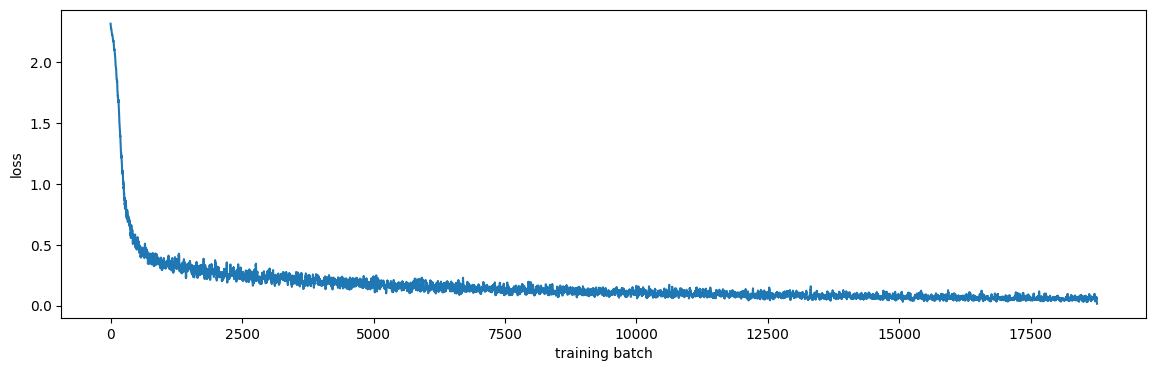

In [351]:
def mean(li): return sum(li)/len(li)
plt.figure(figsize=(14, 4))
plt.xlabel('training batch')
plt.ylabel('loss')
plt.plot([mean(losses[i:i+10]) for i in range(len(losses))])

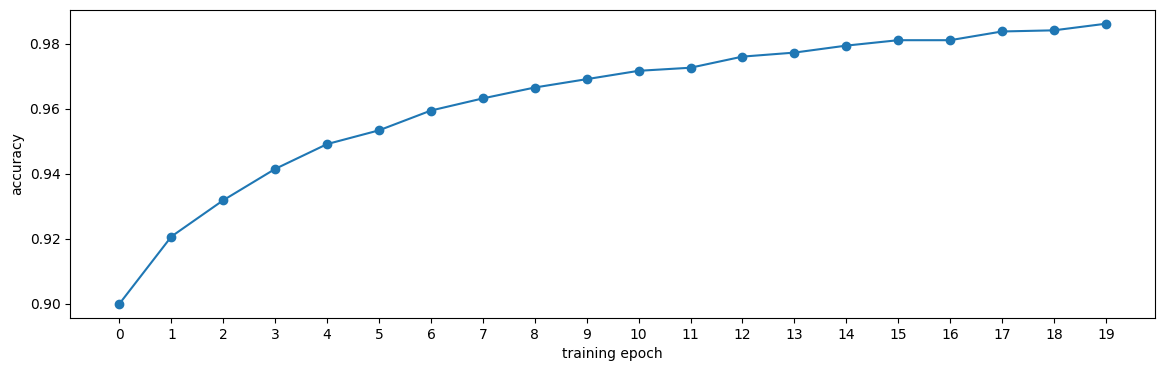

In [352]:
plt.figure(figsize=(14, 4))
plt.xticks(range(len(accuracies)))
plt.xlabel('training epoch')
plt.ylabel('accuracy')
plt.plot(accuracies, marker='o')

In [353]:
def test_label_predictions(model, test_loader):
  model.eval()
  actuals = []
  predictions = []
  with torch.no_grad():
    for data, target in test_loader:
      data = data.reshape(-1, 28*28).to(device)
      target = target.to(device)
      output = model(data)
      prediction = output.argmax(dim=1, keepdim=True)
      actuals.extend(target.view_as(prediction))
      predictions.extend(prediction)
  return [i.item() for i in actuals], [i.item() for i in predictions]

actuals, predictions = test_label_predictions(model, test_loader)
print('Confusion matrix:')
print(confusion_matrix(actuals, predictions))
print('F1 score: %f' % f1_score(actuals, predictions, average='macro'))
print('Accuracy score: %f' % accuracy_score(actuals, predictions))

Confusion matrix:
[[ 965    0    1    1    1    3    5    1    1    2]
 [   0 1123    3    1    0    1    4    1    2    0]
 [   5    2 1004    2    4    1    1    5    7    1]
 [   0    0    5  991    0    2    0    3    6    3]
 [   0    0    5    0  956    1    3    3    2   12]
 [   3    1    1   10    1  860    7    1    5    3]
 [   5    3    0    1    6    5  933    0    5    0]
 [   1    6   11    5    0    0    0  996    2    7]
 [   6    0    2    7    5    3    4    3  941    3]
 [   5    4    2    9    9    2    0    7    4  967]]
F1 score: 0.973390
Accuracy score: 0.973600


In [354]:
def test_class_probabilities(model, test_loader, which_class):
  model.eval()
  actuals = []
  all_actuals = []
  probabilities = []
  all_probabilities = []
  with torch.no_grad():
    for data, target in test_loader:
      data = data.reshape(-1, 28*28).to(device)
      target = target.to(device)
      output = model(data)
      probs = torch.nn.functional.softmax(output, dim=1)
      all_actuals.extend(target.cpu().numpy())
      all_probabilities.extend(probs.numpy())
      prediction = output.argmax(dim=1, keepdim=True)
      actuals.extend(target.view_as(prediction) == which_class)
      probabilities.extend(np.exp(output[:, which_class]))
  return [i.item() for i in actuals], [i.item() for i in probabilities], np.array(all_actuals), np.array(all_probabilities)

Class 0 AUC: 0.998201615457713


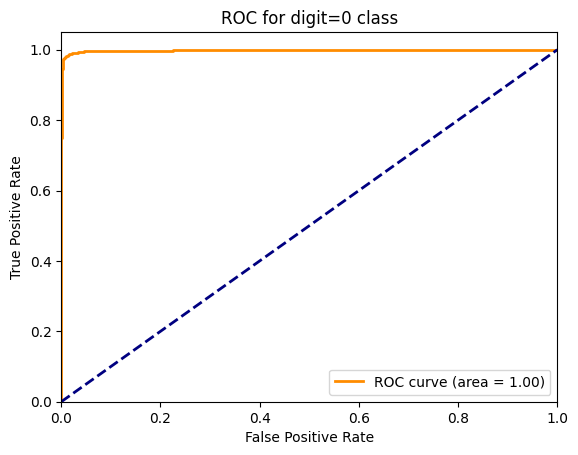

Class 1 AUC: 0.9980793647244148


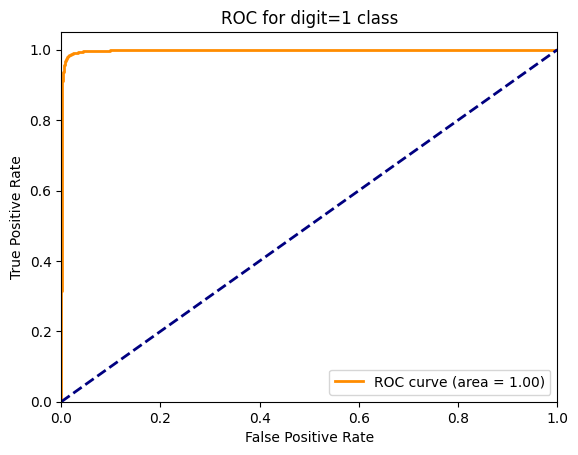

Class 2 AUC: 0.9957549322656266


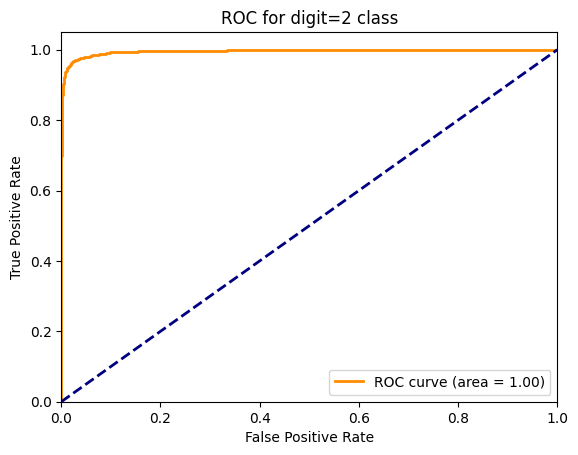

Class 3 AUC: 0.9873316886749853


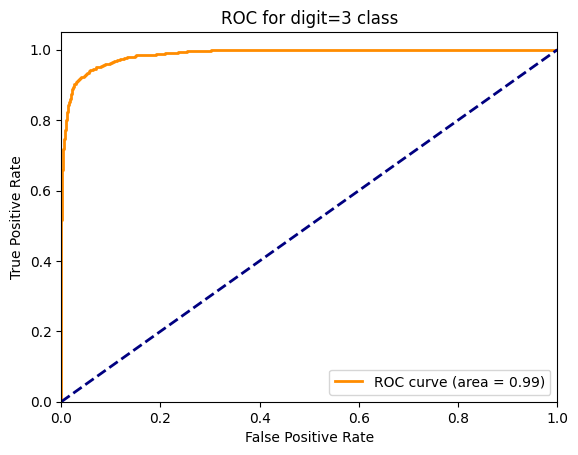

Class 4 AUC: 0.9970280077997433


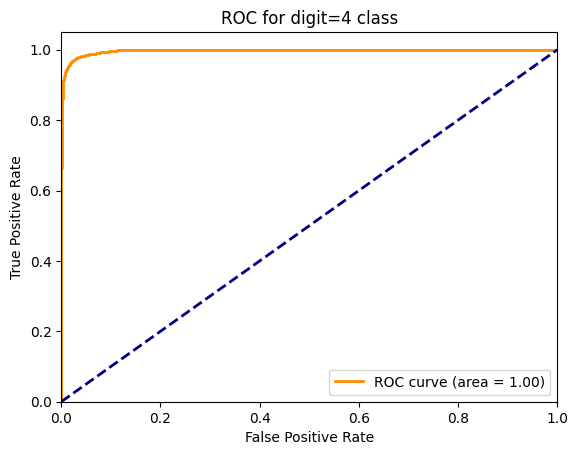

Class 5 AUC: 0.995186068129137


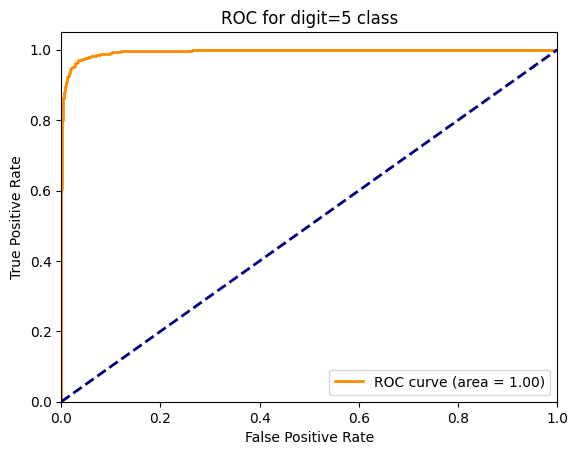

Class 6 AUC: 0.9983202951293407


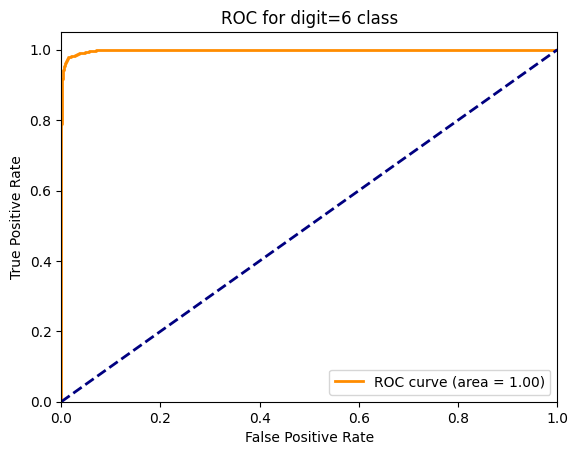

Class 7 AUC: 0.9957202563617723


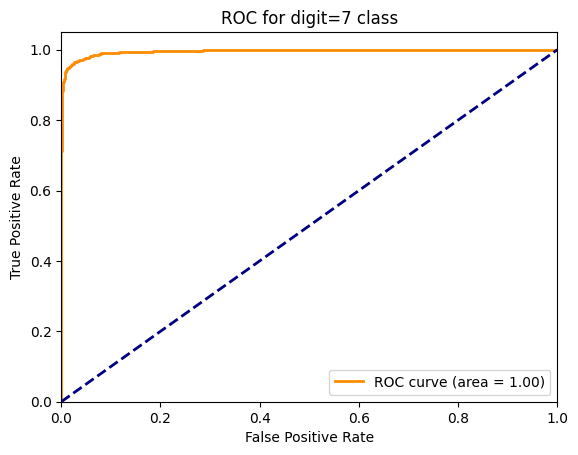

Class 8 AUC: 0.9916128674133726


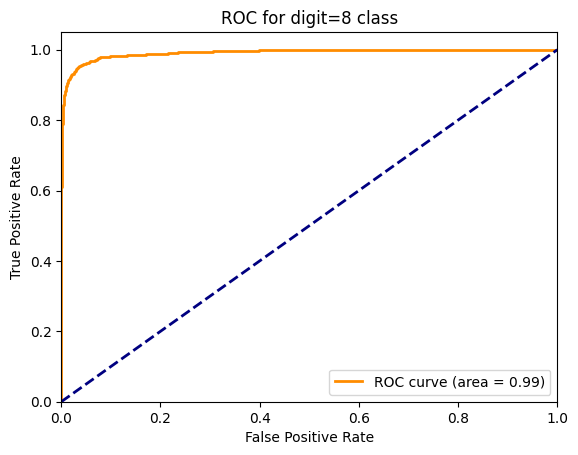

Class 9 AUC: 0.990432233797502


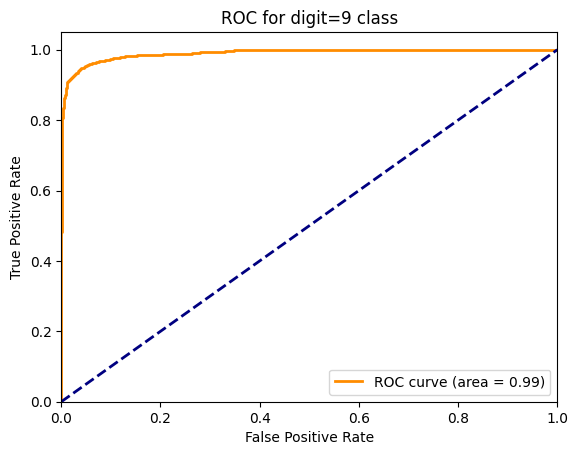

In [355]:
for i in range(10):
  actuals, probabilities, all_ac, all_prob = test_class_probabilities(model, test_loader, i)
  print(f'Class {i} AUC: {roc_auc_score(actuals, probabilities)}')
  fpr, tpr, _ = roc_curve(actuals, probabilities)
  roc_auc = auc(fpr, tpr)
  plt.figure()
  lw = 2
  plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
  plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
  plt.xlim([0.0, 1.0])
  plt.ylim([0.0, 1.05])
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.title('ROC for digit=%d class' % i)
  plt.legend(loc="lower right")
  plt.show()

In [356]:
# Calculate total ROC AUC score
total_roc_auc = roc_auc_score(
    y_true=np.eye(10)[all_ac],  # Convert to one-hot encoding
    y_score=all_prob,
    multi_class='ovr',
    average='macro'
)
print(f'Total ROC AUC score: {total_roc_auc:.4f}')

Total ROC AUC score: 0.9995
